# Drought Network Overlap
9.20.2022, a. stein

Here I want to look into tracing how the same drought evolves differently in different metrics.

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import xarray as xr
import rioxarray
import rasterio as rio
import pandas as pd
import geopandas as gpd
import networkx as nx

import matplotlib.dates as mdates

from tqdm.autonotebook import tqdm

import sys
sys.path.append('../../')
import ndrought.wrangle as wrangle
import ndrought.compare as compare
import ndrought.plotting as ndplot
import ndrought.drought_network as dnet

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/tmp/ipykernel_1081522/2338660029.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Pull some data

In [2]:
dm_path = '/pool0/home/steinadi/data/drought/drought_impact/data/drought_measures'

In [3]:
usdm = xr.open_dataset(f'{dm_path}/usdm/USDM_WA_20000104_20220412.nc')

In [4]:
usdm_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/usdm/usdm_WA_net.pickle')

In [5]:
pdsi = xr.open_dataset(f'{dm_path}/pdsi/WA/pdsi_usdmcat_WA.nc')

In [6]:
pdsi_net = dnet.DroughtNetwork.unpickle(f'{dm_path}/pdsi/WA/pdsi_WA_net.pickle')

Okay, I want things to match time, yet the drought network does not currently store what the actual date is of each network's nodes are. So let's check how they should be paired for these.

In [7]:
matched_dates = compare.pair_to_usdm_date(pd.to_datetime(usdm.date.values), pd.to_datetime(pdsi.day.values), 'PDSI', realign=True)

/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/compare.py:125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pair_dates['USDM Date'].iloc[i-1] = date
/pool0/data/steinjao/drought/drought_impact/notebooks/explore/../../ndrought/compare.py:128: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  pair_dates = pair_dates.dropna('index')


In [8]:
matched_dates

,PDSI,USDM Date
0,1999-12-31,2000-01-04 00:00:00
1,2000-01-10,2000-01-11 00:00:00
2,2000-01-15,2000-01-18 00:00:00
3,2000-01-25,2000-01-25 00:00:00
4,2000-01-30,2000-02-01 00:00:00
...,...,...
1144,2021-12-06,2021-12-07 00:00:00
1145,2021-12-11,2021-12-14 00:00:00
1146,2021-12-21,2021-12-21 00:00:00
1147,2021-12-26,2021-12-28 00:00:00


In [9]:
usdm.date.values[:1149]

array(['2000-01-04T00:00:00.000000000', '2000-01-11T00:00:00.000000000',
       '2000-01-18T00:00:00.000000000', ...,
       '2021-12-21T00:00:00.000000000', '2021-12-28T00:00:00.000000000',
       '2022-01-04T00:00:00.000000000'], dtype='datetime64[ns]')

Okay, if we just go to 1149, then we'll be good

And looks like the times are at the same interval, so we can just check for time equivalency then

In [10]:
overlapped_nodes = dict()

t = tqdm(total=(len(usdm_net.nodes)*len(pdsi_net.nodes)))

for usdm_node in usdm_net.nodes:
    usdm_coord_set = set(tuple(coord) for coord in usdm_node.coords)
    time = usdm_node.time
    for pdsi_node in pdsi_net.nodes:
        if time == pdsi_node.time:
            pdsi_coord_set = set(tuple(coord) for coord in pdsi_node.coords)

            if len(usdm_coord_set.intersection(pdsi_coord_set)) > 0:
                if time not in overlapped_nodes.keys():
                    overlapped_nodes[time] = []
                overlapped_nodes[time].append([usdm_node, pdsi_node])

        t.update()

  0%|          | 0/86991324 [00:00<?, ?it/s]

Alright, what did we get?

In [11]:
overlapped_dates = matched_dates.iloc[list(overlapped_nodes.keys())]

In [12]:
overlapped_dates

,PDSI,USDM Date
58,2001-02-09,2001-02-13 00:00:00
59,2001-02-19,2001-02-20 00:00:00
60,2001-02-24,2001-02-27 00:00:00
61,2001-03-06,2001-03-06 00:00:00
62,2001-03-11,2001-03-13 00:00:00
...,...,...
1144,2021-12-06,2021-12-07 00:00:00
1145,2021-12-11,2021-12-14 00:00:00
1146,2021-12-21,2021-12-21 00:00:00
1147,2021-12-26,2021-12-28 00:00:00


In [13]:
time_index = np.arange(1149)
time_overlapped_binary = []
for time in time_index:
    if time in overlapped_nodes.keys():
        time_overlapped_binary.append(1)
    else:
        time_overlapped_binary.append(0)

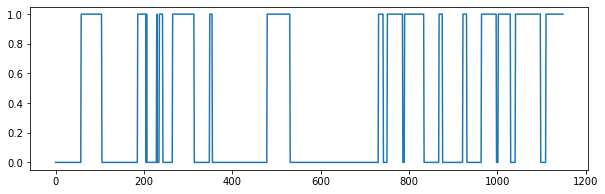

In [14]:
fig, ax = plt.subplots(figsize=(10,3))

ax.plot(time_index, time_overlapped_binary)

So that gives us a sense of when there is overlap.

It's interesting comparing that to the CAF plots, as some definitely align by eye, but where it looks like a drought might align in the CAF plots it doesn't always physically overlap.

In [15]:
overlap_events = []

current_event = []
for time in overlapped_nodes.keys():
    if len(current_event) == 0:
        current_event.append(time)
    elif current_event[-1] == time - 1:
        current_event.append(time)
    else:
        overlap_events.append(current_event)
        current_event = []

if len(current_event) != 0 and overlap_events[-1] != current_event:
    overlap_events.append(current_event)

In [16]:
len(overlap_events)

16

Cool, that matches the number of events I can identify by eye in the above plot

So there are 2 ways I can think that this might be interesting:
- animation overlay of drought events
- creating edges that merge the two graphs at these connection points

In [17]:
event = overlap_events[0]

In [18]:
usdm_overlap_nodes = []
pdsi_overlap_nodes = []

for nodes in overlapped_nodes[58]:
    usdm_node, pdsi_node = nodes
    if usdm_node not in usdm_overlap_nodes:
        usdm_overlap_nodes.append(usdm_node)
    if pdsi_node not in pdsi_overlap_nodes:
        pdsi_overlap_nodes.append(pdsi_node)

In [19]:
usdm_overlap_nodes

[time: 58, id: 3, time: 58, id: 4, time: 58, id: 5]

In [20]:
pdsi_overlap_nodes

[time: 58, id: 533,
 time: 58, id: 543,
 time: 58, id: 545,
 time: 58, id: 546,
 time: 58, id: 549,
 time: 58, id: 555,
 time: 58, id: 556,
 time: 58, id: 559,
 time: 58, id: 560,
 time: 58, id: 562,
 time: 58, id: 564,
 time: 58, id: 565,
 time: 58, id: 566,
 time: 58, id: 567,
 time: 58, id: 568,
 time: 58, id: 569,
 time: 58, id: 570,
 time: 58, id: 571,
 time: 58, id: 572,
 time: 58, id: 573,
 time: 58, id: 574,
 time: 58, id: 575,
 time: 58, id: 576,
 time: 58, id: 577,
 time: 58, id: 578,
 time: 58, id: 542,
 time: 58, id: 552]

In [21]:
usdm_event_adj_dicts = []
pdsi_event_adj_dicts = []

for event in overlap_events:
    usdm_overlap_ids = []
    pdsi_overlap_ids = []
    for time in event:
        for usdm_node, pdsi_node in overlapped_nodes[time]:
            usdm_id = usdm_node.id
            pdsi_id = pdsi_node.id
            if usdm_id not in usdm_overlap_ids:
                usdm_overlap_ids.append(usdm_id)
            if pdsi_id not in pdsi_overlap_ids:
                pdsi_overlap_ids.append(pdsi_id)
    usdm_event_adj_dicts.append(usdm_net.filter_adj_dict_by_id(usdm_overlap_ids))
    pdsi_event_adj_dicts.append(pdsi_net.filter_adj_dict_by_id(pdsi_overlap_ids))

ani_folder = '/pool0/home/steinadi/data/drought/drought_impact/animations/usdm_pdsi_overlap'

t = tqdm(total=len(overlap_events)*2)

for i, (usdm_adj_dict, pdsi_adj_dict) in enumerate(zip(usdm_event_adj_dicts, pdsi_event_adj_dicts)):

    times = np.array(overlap_events[i])

    usdm_net.create_animated_gif(out_path=f'{ani_folder}/usdm_{i}.gif', adj_dict=usdm_adj_dict, times=times)
    t.update()

    pdsi_net.create_animated_gif(out_path=f'{ani_folder}/pdsi_{i}.gif', adj_dict=pdsi_adj_dict, times=times)
    t.update()

ani_folder = '/pool0/home/steinadi/data/drought/drought_impact/animations/usdm_pdsi_overlap'

t = tqdm(total=len(overlap_events)*2)

for i, (usdm_adj_dict, pdsi_adj_dict) in enumerate(zip(usdm_event_adj_dicts, pdsi_event_adj_dicts)):

    times = np.array(overlap_events[i])

    usdm_net.create_animated_gif(out_path=f'{ani_folder}/nb_usdm_{i}.gif', adj_dict=usdm_adj_dict, times=times, nonbinary_data=usdm['USDM'].values[overlap_events[i], :, :])
    t.update()

    pdsi_net.create_animated_gif(out_path=f'{ani_folder}/nb_pdsi_{i}.gif', adj_dict=pdsi_adj_dict, times=times, nonbinary_data=pdsi['pdsi'].values[overlap_events[i], :, :])
    t.update()

Okay, that yielded some interesting things. Let's put this into a function